<a href="https://colab.research.google.com/github/Elshan777/MIT-Indoor-Scenes/blob/master/SAML_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1 - Image Classification

This notebook contains the required task for the first assignment of the Software for Advanced Machine Learning course. Read the task description and implement the empty code cells. Each section represents a stage along implementing an image classifier, from loading and inspecting the dataset to training a **pre-trained** Convolutional Neural Network architecture. The sections are to guide you but you do not have to follow that specific order. 

Copy this notebook to your drive (File -> Save a copy in Drive), edit it and upload the final ipynb file to [Canvas](https://canvas.elte.hu) or upload the link to the Colab notebook itself. If you have your own machine with Jupyter installed, you can work there as well.

**Note** Make sure the notebook is using GPU accelerataion in Edit -> Notebook settings, otherwise training and evaluation can be very slow.

## Rules and Comments
- From the list of datasets and architectures listed in canvas, each student was atributed **1 dataset and 1 architecture** to use within this assignment. Please confirm yours in the Canvas assignment's description. 
- This is an DL class so to pass the homework you do have to implement a working classifier, just loading the data or having a "random-guess" performance is not enough.
- As always, copying others' code will make you fail the homework automatically (and thus the course). Remember that you will have to defend the assignment at the end of the semester.
- **Deadline is March 25**
- Make sure your code can be run from an empty state (use Runtime -> Run all in the menu after restarting the notebook)
- Feel free to add more code cells as needed. But don't put code into external Python files to ease the reviewing.
- Please add your name and Neptun ID below for easier identification.

**Name: Elshan Gadimov** 

**Neptun ID: OV7MIK** 

## Task description
Your task is to train an already pretrained Convolutional Neural Network architecture on a dataset, both given in canvas. The datasets contain images as input and class labels as target, thus you have to solve a Supervised Machine Learning Classification problem. 

The dataset shoud be divided into train, validation and test set, for which results should be presented for all.

You can either train the architecture you were given without changing its layers, or you can add more layers, if you believe it increases the accuracy. There is no expected percentage of accuracy, but **your accuracy should be better than random guessing and your loss has to decrease throughout the epochs**. We expect you to show visualisations (any of the following: matplotlib, seaborn, tensorboard, ...) of the accuracy and loss and use Early stopping while training your network.



## 0. Import libraries
Import all libraries/packages that you believe will help you fulfil the task, but **for the network only PyTorch can be used.**

In [21]:
# ADD YOUR CODE HERE
import numpy as np

import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from torch.utils.data import DataLoader
import os
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torchvision.utils import make_grid 
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

## 1. Dataset 
Load the dataset you were given. Images should be stored in an X variable and your labels in a Y variable. Split your dataset into train, validation and test set and pre-process your data for training.

#### Loading the dataset
Show some images and labels of your dataset

In [2]:
#!pip install kaggle

#! mkdir ~/.kaggle

#! cp kaggle.json ~/.kaggle/

#! chmod 600 ~/.kaggle/kaggle.json

os.environ['KAGGLE_USERNAME'] = "elshangadimov"
os.environ['KAGGLE_KEY'] = "dc78ef611b838449f7a58960e2a15014"

! kaggle datasets download itsahmad/indoor-scenes-cvpr-2019

 99% 2.31G/2.34G [00:10<00:00, 216MB/s]
100% 2.34G/2.34G [00:10<00:00, 234MB/s]


In [ ]:
! unzip indoor-scenes-cvpr-2019

In [4]:
# Reading the data
data_dir  = '/content/indoorCVPR_09/Images'

classes = os.listdir(data_dir)
print(classes)
print(len(classes), "Existing classes")

['casino', 'studiomusic', 'movietheater', 'warehouse', 'mall', 'florist', 'concert_hall', 'closet', 'prisoncell', 'hairsalon', 'grocerystore', 'gym', 'dentaloffice', 'restaurant', 'inside_bus', 'trainstation', 'bedroom', 'auditorium', 'kindergarden', 'pantry', 'buffet', 'bathroom', 'cloister', 'computerroom', 'lobby', 'laboratorywet', 'operating_room', 'meeting_room', 'nursery', 'classroom', 'museum', 'shoeshop', 'jewelleryshop', 'bakery', 'greenhouse', 'videostore', 'waitingroom', 'elevator', 'fastfood_restaurant', 'gameroom', 'laundromat', 'restaurant_kitchen', 'tv_studio', 'children_room', 'kitchen', 'library', 'corridor', 'toystore', 'dining_room', 'airport_inside', 'church_inside', 'office', 'artstudio', 'deli', 'inside_subway', 'clothingstore', 'bookstore', 'locker_room', 'bar', 'poolinside', 'livingroom', 'winecellar', 'garage', 'hospitalroom', 'bowling', 'stairscase', 'subway']
67 Existing classes


In [34]:
# ADD YOUR CODE HERE

mean , std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
# 
transformations = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize((256, 256)), 
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])

dataset = ImageFolder(data_dir, transform = transformations)

len(dataset)

15620

In [35]:
# Defining the random seed for torch
random_seed = 42
torch.manual_seed(random_seed)



#### Splitting the dataset

In [36]:
# I did a 80:10:10 split
train_ds, val_ds, test_ds = random_split(dataset, [12496, 1562, 1562])
len(train_ds), len(val_ds), len(test_ds)

(12496, 1562, 1562)

In [37]:
batch_size = 5

train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True, num_workers=2)
valid_dl = DataLoader(val_ds,batch_size=batch_size, num_workers=2)
test_dl = DataLoader(test_ds,batch_size=batch_size,num_workers=2)

## Showing the batch

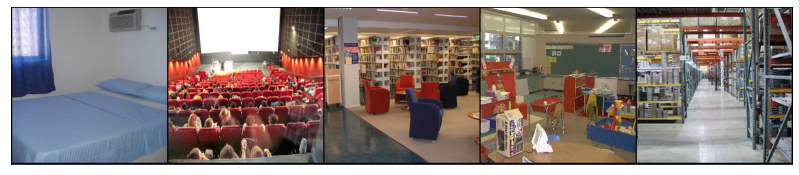

In [41]:
def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', train_dl.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, mean, std)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(14, 14))
        ax.set_xticks([]); ax.set_yticks([])
        images = denormalize(images[:64], mean, std)
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

show_batch(train_dl)

In [ ]:
# ADD YOUR CODE HERE


#### Pre-processing the dataset

In [ ]:
# ADD YOUR CODE HERE

## 2. Convolutional Neural Network Architecture
Load the CNN architecture you were given using pretrained weights. Define the optimizer and loss function. Train your network and save it. Remember to use Early stopping and show results.

#### Load the architecture

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [43]:
# ADD YOUR CODE HERE

# Loading pre trained Alexnet from Pytorch
alexnet = models.alexnet(pretrained=True)
print(alexnet)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Fine tuning the model

In [44]:
model_ft = alexnet
num_ftrs = model_ft.fc.in_features

AttributeError: ignored

In [ ]:
model_ft = alexnet
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(classes))

model_ft = model_ft.to(device)

#### Define your optimizer and loss function

In [ ]:
# ADD YOUR CODE HERE

#### Train your network

In [ ]:
# ADD YOUR CODE HERE

#### Show results (accuracy and loss) on training and validation sets

In [ ]:
# ADD YOUR CODE HERE

## 3. Conclusion (Evaluation)
Load your trained CNN and evaluate it on the test set. Show some predictions on the test set (3 is enough) by ploting the image and printing the prediction and ground truth.

How good are your results? Do you think the network is overfitted or underfitted? If yes, what do you think lead to that? If not, justify.

#### Evaluate your model

In [ ]:
# ADD YOUR CODE HERE

#### Show some predictions

In [ ]:
# ADD YOUR CODE HERE

#### Answer the questions

In [ ]:
# ADD YOUR ANSWERS HERE